# EDA (Exploratory Data Analysis) for NLP

The goal of this EDA (as every EDA actually) is to determine useful information and insight to attain or at least help us attain our goal.

I won't get much of your time, so to resume what I want to do with this project:
- A classification model, which would take either a movie name or a synopsis and try to find the correct genre associated with it.
- The second would be a summarizer the goal is to give the script of a movie and get a synopsis that could get used.



But before diving in the fun part of those models, let's see what we have. For this project I'll use a portion of the dataset available [here](https://huggingface.co/datasets/adrienheymans/imdb-movie-genres/viewer/default/train?p=542). 

At first I've tried other option like use free API (Imdb, Omdb) to retrieve movie name, synopsis, genres, director, actors etc.. But at the end of the day, the best way to have good quality and numerous data is now through HuggingFace (take it with a pinch of salt).

### Disclaimer

- Huggingface split this dataset as a train test. When looking at front information I'll keep in my mind to look both split.

- I'll only use 2*10k rows from the originals datasets, because both of them are 50k rows long, which, as you must know already, is pretty compute power consuming. If by any chance It look like that this number of row is too low I'll increase it through this notebook.

- I want to use the opportunity of this project to get familiar with one of the concurrent of pandas, [polars](https://pola.rs/) it's said to be faster and better overall.

- To do this EDA I helped myself with some documentation found over internet feel free to check them in the README file under sectcion *source*

### Front information

If we look at huggingface for information about the dataset let's see what we get ([Here](https://huggingface.co/datasets/adrienheymans/imdb-movie-genres) if you want to see along the file):

```
Dataset Card for "imdb-movie-genres"
MDb (an acronym for Internet Movie Database) is an online database of information related to films, television programs, home videos, video games, and streaming content online – including cast, production crew and personal biographies, plot summaries, trivia, ratings, and fan and critical reviews. An additional fan feature, message boards, was abandoned in February 2017. Originally a fan-operated website, the database is now owned and operated by IMDb.com, Inc., a subsidiary of Amazon.

As of December 2020, IMDb has approximately 7.5 million titles (including episodes) and 10.4 million personalities in its database,[2] as well as 83 million registered users.

IMDb began as a movie database on the Usenet group "rec.arts.movies" in 1990 and moved to the web in 1993.

Provenance : ftp://ftp.fu-berlin.de/pub/misc/movies/database/
```

We see both train and test dataset have 4 features **title, text, genre, labels** now for each features : 
- **title** is of type string and range from 8 to 215 characters 71.1% are 8-29 char long for train split and 47.3% are 21-34 char long for test split. It seems that title are formatted as follow "\<Title\> (\<release year\>)" but for some of them have an additional \\I in the release year or are unknown, I'll have to keep that in mind if I want to extract the release date later.
- **text** is of type string and are filtered by lengths, 89.8% are 41 to 1.09k char long for train split and 85.7% are 37 to 942 char long in test split.
- **genre** is of type string and filtered by classes, there's 27 values 25.1% of genre are drama in both test and train split
- **label** is of type int and range from 0 to 26 (27 values), after going through it seems, as expected, that label are here to link to genre. It will help us gain time.

the dataset is exclusively english which help us in a way.

now let's get our hands dirty.

In [62]:
# Import cell
import polars as pl
import nltk
nltk.download('stopwords')

import os
PARENT_FOLDER = globals()['_dh'][0]

import seaborn as sns
import gensim
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from num2words import num2words
import re
from string import punctuation


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\littl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Import dataset
TRAIN_FILEPATH = os.path.join(PARENT_FOLDER, "data_exploration","train.csv")
TEST_FILEPATH = os.path.join(PARENT_FOLDER, "data_exploration", "test.csv")
train_df_original = pl.read_csv(TRAIN_FILEPATH)
test_df_original = pl.read_csv(TEST_FILEPATH)

Since for now we're not gonna change anything in the dataset let's make copy later.

In [5]:
print(train_df_original.describe())
print(test_df_original.describe())

shape: (9, 5)
┌────────────┬─────────────────────────────────┬──────────────────────────┬─────────┬──────────┐
│ statistic  ┆ title                           ┆ text                     ┆ genre   ┆ label    │
│ ---        ┆ ---                             ┆ ---                      ┆ ---     ┆ ---      │
│ str        ┆ str                             ┆ str                      ┆ str     ┆ f64      │
╞════════════╪═════════════════════════════════╪══════════════════════════╪═════════╪══════════╡
│ count      ┆ 10000                           ┆ 10000                    ┆ 10000   ┆ 10000.0  │
│ null_count ┆ 0                               ┆ 0                        ┆ 0       ┆ 0.0      │
│ mean       ┆ null                            ┆ null                     ┆ null    ┆ 5.5613   │
│ std        ┆ null                            ┆ null                     ┆ null    ┆ 5.979818 │
│ min        ┆ "1,000 Places to See Before Yo… ┆ " i want to make a       ┆ action  ┆ 0.0      │
│            ┆  

Okay everything seems alright, of course on string feature we wouldn't see much, but we have our 10_000 rows, label is ranged from 0 through 26, and something that seem plausible but a bit curious is there's no null_count. 

Let's check further if there's really no null values.

In [3]:
train_df = train_df_original.clone()
test_df = test_df_original.clone()
# Train df
train_null_count = train_df.select([pl.col(col).is_null().sum().alias(col + "_null_count") for col in train_df.columns])
# Test df
test_null_count = test_df.select([pl.col(col).is_null().sum().alias(col + "_null_count") for col in test_df.columns])

print(train_null_count)
print(test_null_count)

shape: (1, 4)
┌──────────────────┬─────────────────┬──────────────────┬──────────────────┐
│ title_null_count ┆ text_null_count ┆ genre_null_count ┆ label_null_count │
│ ---              ┆ ---             ┆ ---              ┆ ---              │
│ u32              ┆ u32             ┆ u32              ┆ u32              │
╞══════════════════╪═════════════════╪══════════════════╪══════════════════╡
│ 0                ┆ 0               ┆ 0                ┆ 0                │
└──────────────────┴─────────────────┴──────────────────┴──────────────────┘
shape: (1, 4)
┌──────────────────┬─────────────────┬──────────────────┬──────────────────┐
│ title_null_count ┆ text_null_count ┆ genre_null_count ┆ label_null_count │
│ ---              ┆ ---             ┆ ---              ┆ ---              │
│ u32              ┆ u32             ┆ u32              ┆ u32              │
╞══════════════════╪═════════════════╪══════════════════╪══════════════════╡
│ 0                ┆ 0               ┆ 0        

Okay everything seems alright no null values ! Let's pursue.

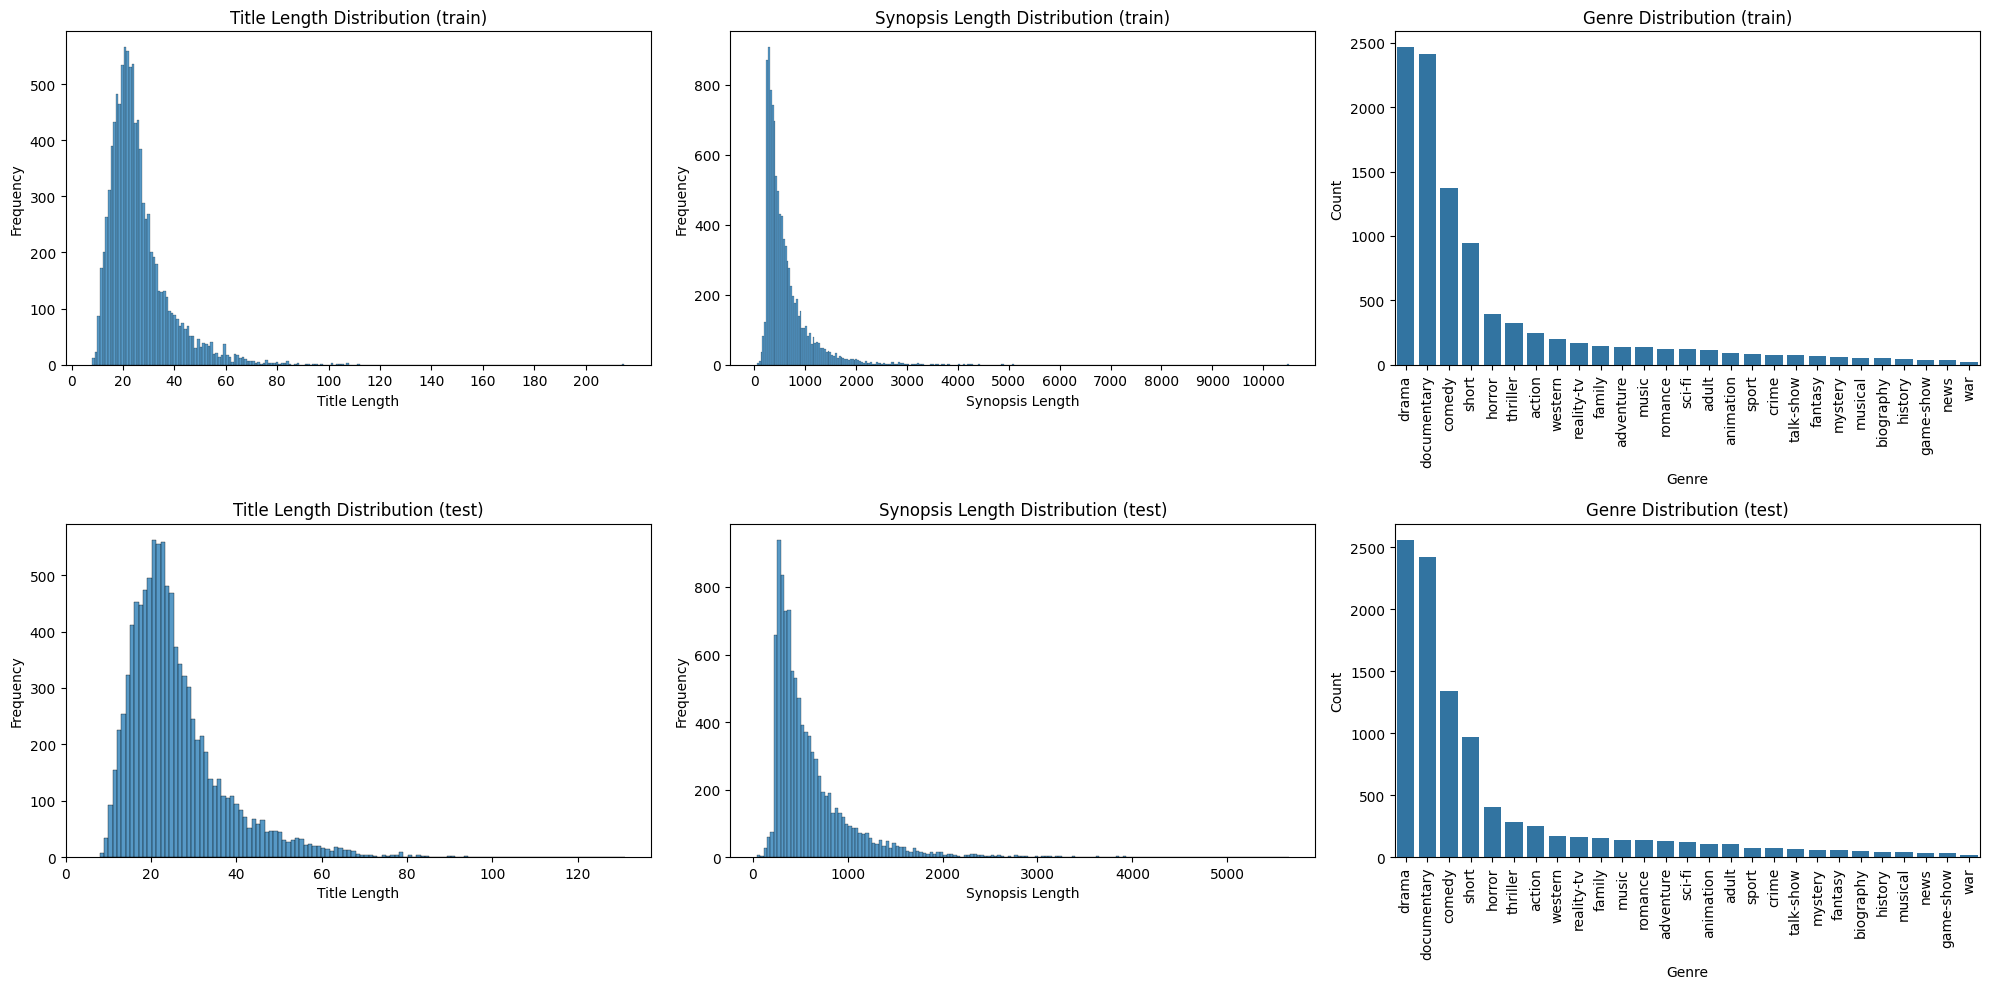

In [34]:
train_df_lengths = train_df.select(
    pl.col("title").str.len_chars().alias("title_length"),
    pl.col("text").str.len_chars().alias("text_length"),
)
train_df_genre_counts = train_df['genre'].value_counts().sort("count", descending=True)


test_df_lengths = test_df.select(
    pl.col("title").str.len_chars().alias("title_length"),
    pl.col("text").str.len_chars().alias("text_length"),
)
test_df_genre_counts = test_df['genre'].value_counts().sort("count", descending=True)

# And now let's plot !

fig, axes = plt.subplots(2,3, figsize=(20,10))

sns.histplot(train_df_lengths['title_length'], ax= axes[0][0])
axes[0][0].set_title("Title Length Distribution (train)")
axes[0][0].set_xlabel("Title Length")
axes[0][0].set_xticks(np.arange(0, max(train_df_lengths['title_length']), 20))
axes[0][0].set_ylabel("Frequency")

sns.histplot(train_df_lengths['text_length'], ax= axes[0][1])
axes[0][1].set_title("Synopsis Length Distribution (train)")
axes[0][1].set_xlabel("Synopsis Length")
axes[0][1].set_xticks(np.arange(0, max(train_df_lengths['text_length']), 1000))
axes[0][1].set_ylabel("Frequency")

sns.barplot(x=train_df_genre_counts['genre'], y=train_df_genre_counts['count'], ax= axes[0][2])
axes[0][2].set_title("Genre Distribution (train)")
axes[0][2].set_xlabel("Genre")
axes[0][2].tick_params(axis='x', rotation=90)
axes[0][2].set_ylabel("Count")

sns.histplot(test_df_lengths['title_length'], ax= axes[1][0])
axes[1][0].set_title("Title Length Distribution (test)")
axes[1][0].set_xlabel("Title Length")
axes[1][0].set_xticks(np.arange(0, max(test_df_lengths['title_length']), 20))
axes[1][0].set_ylabel("Frequency")

sns.histplot(test_df_lengths['text_length'], ax= axes[1][1])
axes[1][1].set_title("Synopsis Length Distribution (test)")
axes[1][1].set_xlabel("Synopsis Length")
axes[1][1].set_xticks(np.arange(0, max(test_df_lengths['text_length']), 1000))
axes[1][1].set_ylabel("Frequency")

sns.barplot(x=test_df_genre_counts['genre'], y=test_df_genre_counts['count'], ax= axes[1][2])
axes[1][2].set_title("Genre Distribution (test)")
axes[1][2].set_xlabel("Genre")
axes[1][2].tick_params(axis='x', rotation=90)
axes[1][2].set_ylabel("Count")


plt.tight_layout()
plt.show()


Okay as we can see both *train* and *test* seems to have the same repartition, with nonetheless some difference on train where there are some row with a greater title length and synopsis length. But Otherwise the genre distribution seems to be, not evenly reparted but still in the same order and proportion in both dataset.

I want to check that in genre we don't have a genre that is classified as "unknown" or something like that, we wouldn't want that in our dataset.

In [40]:

pprint(test_df_genre_counts['genre'].to_list())

['drama',
 'documentary',
 'comedy',
 'short',
 'horror',
 'thriller',
 'action',
 'western',
 'reality-tv',
 'family',
 'music',
 'romance',
 'adventure',
 'sci-fi',
 'animation',
 'adult',
 'sport',
 'crime',
 'talk-show',
 'mystery',
 'fantasy',
 'biography',
 'history',
 'musical',
 'news',
 'game-show',
 'war']


Okay all good on this side.

Let's dig now into the real fun part, **cleaning synopsis**.

### Cleansing & tokenization

Let's see one synopsis to look at how our string is formatted.

In [41]:
pprint(train_df['text'][0])

('listening in to a conversation between his doctor and parents, 10-year-old '
 'oscar learns what nobody has the courage to tell him. he only has a few '
 'weeks to live. furious, he refuses to speak to anyone except '
 'straight-talking rose, the lady in pink he meets on the hospital stairs. as '
 'christmas approaches, rose uses her fantastical experiences as a '
 'professional wrestler, her imagination, wit and charm to allow oscar to live '
 'life and love to the full, in the company of his friends pop corn, einstein, '
 'bacon and childhood sweetheart peggy blue.')


Okay what we can see a lot of surprising things in this synopsis, first there's no capital letter, there's still come punctuations, but what is the most surprising there's no contraction such as "wasn't, didn't, I'll, etc.." which is very rare.

Let's print some more rows and check if it's constant. 

In [45]:
for i in range(1,6):
    print(train_df['text'][i]) # I use print here because pprint sometimes uses simple quote and double quote which can be misleading

a brother and sister with a past incestuous relationship have a current murderous relationship. he murders the women who reject him and she murders the women who get too close to him.
as the bus empties the students for their field trip to the museum of natural history, little does the tour guide suspect that the students are there for more than just another tour. first, during the lecture films, the coeds drift into dreams of the most erotic fantasies one can imagine. after the films, they release the emotion of the fantasies in the most erotic and uncommon ways. one slips off to the curator's office for a little "acquisition. " another finds the anthropologist to see what bones can be identified. even the head teacher isn't immune. soon the tour is over, but as the bus departs, everyone admits it was quite an education.
to help their unemployed father make ends meet, edith and her twin sister grace work as seamstresses . an invalid, grace falls prey to the temptations of chinatown op

Ok so from what we can see still no capital letter, punctuations still present, and there's contraction ! So we add this to our list of processes to apply on our synopses.

Also I want to draw your attention on the fourth line where two dates are displayed **september 11 and halloween of 2001** this indicate us something, we can't remove digits from our synopses, so as a counterpart we want to convert those dates to full plain string, so **september 11** become **september eleven**.

Let's start our cleaning step by step.

In [ ]:
# First let's make a copy of our feature 'text' to 'clean_text' this way we will work only on this feature.

train_df = train_df.with_columns(
    pl.col('text').alias('clean_text')
)

test_df = test_df.with_columns(
    pl.col('text').alias('clean_text')
)

# Then let's change digits to str we'll need to build some functions to have a more accurate result

def convert_ordinals(text: str) -> str:
    def ordinal_replacer(match: re.Match):
        number = int(match.group(1))
        return num2words(number, to='ordinal')

    return re.sub(r'\b(\d+)(st|nd|rd|th)\b', ordinal_replacer, text) # Regex : https://regex101.com/r/iyqb2p/1

def convert_cardinals(text: str) -> str:
    def cardinal_replacer(match: re.Match):
        number = int(match.group(1))
        return num2words(number)
    return re.sub(r'(\d+)', cardinal_replacer, text) # Regex capture all number

def convert_all_numbers(text: str) -> str:
    # first convert all ordinals numbers
    text = convert_ordinals(text)
    # And then cardinals
    return convert_cardinals(text)

train_df = train_df.with_columns(
    pl.col('clean_text').map_elements(convert_all_numbers, return_dtype=pl.String).alias("clean_text")
)

test_df = test_df.with_columns(
    pl.col('clean_text').map_elements(convert_all_numbers, return_dtype=pl.String).alias("clean_text")
)

# Let's see if it works


In [59]:
for i in range(1,6):
    print(train_df['clean_text'][i])

a brother and sister with a past incestuous relationship have a current murderous relationship. he murders the women who reject him and she murders the women who get too close to him.
as the bus empties the students for their field trip to the museum of natural history, little does the tour guide suspect that the students are there for more than just another tour. first, during the lecture films, the coeds drift into dreams of the most erotic fantasies one can imagine. after the films, they release the emotion of the fantasies in the most erotic and uncommon ways. one slips off to the curator's office for a little "acquisition. " another finds the anthropologist to see what bones can be identified. even the head teacher isn't immune. soon the tour is over, but as the bus departs, everyone admits it was quite an education.
to help their unemployed father make ends meet, edith and her twin sister grace work as seamstresses . an invalid, grace falls prey to the temptations of chinatown op

In [ ]:
# Let's keep going, now that the digit have been taken care of let's remove punctuations and excess whitespace

train_df = train_df.with_columns(
    pl.col('clean_text')
    .str.replace_all(r'[%s]' % re.escape(punctuation), '')
    .str.replace_all(r'\s+', ' ')
    .alias('clean_text')
)

test_df = test_df.with_columns(
    pl.col('clean_text')
    .str.replace_all(r'[%s]' % re.escape(punctuation), '')
    .str.replace_all(r'\s+',' ')
    .alias('clean_text')
)



In [64]:
for i in range(1,6):
    print(train_df['clean_text'][i])

a brother and sister with a past incestuous relationship have a current murderous relationship he murders the women who reject him and she murders the women who get too close to him
as the bus empties the students for their field trip to the museum of natural history little does the tour guide suspect that the students are there for more than just another tour first during the lecture films the coeds drift into dreams of the most erotic fantasies one can imagine after the films they release the emotion of the fantasies in the most erotic and uncommon ways one slips off to the curators office for a little acquisition another finds the anthropologist to see what bones can be identified even the head teacher isnt immune soon the tour is over but as the bus departs everyone admits it was quite an education
to help their unemployed father make ends meet edith and her twin sister grace work as seamstresses an invalid grace falls prey to the temptations of chinatown opium and becomes an addic